In [4]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scorecardpy as sc
from string import ascii_letters
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
%matplotlib inline

# Prepare the Data

In [67]:
# create a list of variable names for the data set
varList = pd.read_excel("CC_VariablesList.XLS")
varNames = varList.loc[:,"Var_Title"].to_numpy()
varNames[43]= "MATE_EDUCATION_LEVEL"
# update the variable name which has the same with a previous variable names
print(varNames[43])

MATE_EDUCATION_LEVEL


In [68]:
# read in data
df = pd.read_csv("CC_Modeling_Data.txt",header=None,encoding="unicode_escape",delimiter="\t",names=varNames)
print(df.head())

   ID_CLIENT CLERK_TYPE  PAYMENT_DAY APPLICATION_SUBMISSION_TYPE  \
0          1          C            5                         Web   
1          2          C           15                       Carga   
2          3          C            5                         Web   
3          4          C           20                         Web   
4          5          C           10                         Web   

   QUANT_ADDITIONAL_CARDS  POSTAL_ADDRESS_TYPE SEX  MARITAL_STATUS  \
0                       0                    1   F               6   
1                       0                    1   F               2   
2                       0                    1   F               2   
3                       0                    1   F               2   
4                       0                    1   M               2   

   QUANT_DEPENDANTS  EDUCATION_LEVEL  ... FLAG_HOME_ADDRESS_DOCUMENT FLAG_RG  \
0                 1                0  ...                          0       0   
1         

W:\Tools\Anaconda3\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (51,52) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [69]:
# check if any variables only contain a single value which would not contribute to our logisticregression
for i in np.arange(len(varNames)):
  distinct = len(df.iloc[:,i].unique())
  if distinct < 2:
    print(i, " ", varNames[i])


1   CLERK_TYPE
4   QUANT_ADDITIONAL_CARDS
9   EDUCATION_LEVEL
20   FLAG_MOBILE_PHONE
44   FLAG_HOME_ADDRESS_DOCUMENT
45   FLAG_RG
46   FLAG_CPF
47   FLAG_INCOME_PROOF
49   FLAG_ACSP_RECORD


In [70]:
# remove those unhelpful variables and identity based variables
my_columns = np.r_[2:4,5:6,7:9,10:20,21:44,48,50:len(df.columns)]
df2 = df.iloc[:,my_columns]
print("Now there are ",len(df2.columns), " variables left")

# take a look at the distributions of the variables in general
df2.describe()

Now there are  43  variables left


,PAYMENT_DAY,POSTAL_ADDRESS_TYPE,MARITAL_STATUS,QUANT_DEPENDANTS,NACIONALITY,RESIDENCE_TYPE,MONTHS_IN_RESIDENCE,FLAG_EMAIL,PERSONAL_MONTHLY_INCOME,OTHER_INCOMES,...,PERSONAL_ASSETS_VALUE,QUANT_CARS,MONTHS_IN_THE_JOB,PROFESSION_CODE,OCCUPATION_TYPE,MATE_PROFESSION_CODE,MATE_EDUCATION_LEVEL,PRODUCT,AGE,TARGET_LABEL_BAD=1
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,48651.000000,46223.000000,50000.000000,50000.000000,50000.000000,...,5.000000e+04,50000.000000,50000.000000,42244.000000,42687.000000,21116.000000,17662.000000,50000.000000,50000.00000,50000.000000
mean,12.869920,1.006540,2.14840,0.650520,0.961600,1.252225,9.727149,0.802280,886.678437,35.434760,...,2.322372e+03,0.336140,0.009320,8.061784,2.484316,3.797926,0.296003,1.275700,43.24852,0.260820
std,6.608385,0.080606,1.32285,1.193655,0.202105,0.867833,10.668841,0.398284,7846.959327,891.515142,...,4.235798e+04,0.472392,0.383453,3.220104,1.532261,5.212168,0.955688,0.988286,14.98905,0.439086
min,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.00000,0.000000
25%,10.000000,1.000000,1.00000,0.000000,1.000000,1.000000,1.000000,1.000000,360.000000,0.000000,...,0.000000e+00,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,1.000000,31.00000,0.000000
50%,10.000000,1.000000,2.00000,0.000000,1.000000,1.000000,6.000000,1.000000,500.000000,0.000000,...,0.000000e+00,0.000000,0.000000,9.000000,2.000000,0.000000,0.000000,1.000000,41.00000,0.000000
75%,15.000000,1.000000,2.00000,1.000000,1.000000,1.000000,15.000000,1.000000,800.000000,0.000000,...,0.000000e+00,1.000000,0.000000,9.000000,4.000000,11.000000,0.000000,1.000000,53.00000,1.000000
max,25.000000,2.000000,7.00000,53.000000,2.000000,5.000000,228.000000,1.000000,959000.000000,194344.000000,...,6.000000e+06,1.000000,35.000000,18.000000,5.000000,17.000000,5.000000,7.000000,106.00000,1.000000


# Data Cleaning

## check for Null values

In [71]:
# find out which columns have null values
df2.isnull().any()

PAYMENT_DAY                       False
APPLICATION_SUBMISSION_TYPE       False
POSTAL_ADDRESS_TYPE               False
MARITAL_STATUS                    False
QUANT_DEPENDANTS                  False
STATE_OF_BIRTH                    False
CITY_OF_BIRTH                     False
NACIONALITY                       False
RESIDENCIAL_STATE                 False
RESIDENCIAL_CITY                  False
RESIDENCIAL_BOROUGH               False
FLAG_RESIDENCIAL_PHONE            False
RESIDENCIAL_PHONE_AREA_CODE       False
RESIDENCE_TYPE                     True
MONTHS_IN_RESIDENCE                True
FLAG_EMAIL                        False
PERSONAL_MONTHLY_INCOME           False
OTHER_INCOMES                     False
FLAG_VISA                         False
FLAG_MASTERCARD                   False
FLAG_DINERS                       False
FLAG_AMERICAN_EXPRESS             False
FLAG_OTHER_CARDS                  False
QUANT_BANKING_ACCOUNTS            False
QUANT_SPECIAL_BANKING_ACCOUNTS    False


In [72]:
# find how many null values those columns have
null_columns = df2.columns[df2.isnull().any()]
df2[null_columns].isnull().sum()

RESIDENCE_TYPE           1349
MONTHS_IN_RESIDENCE      3777
PROFESSIONAL_CITY       33783
PROFESSIONAL_BOROUGH    33783
PROFESSION_CODE          7756
OCCUPATION_TYPE          7313
MATE_PROFESSION_CODE    28884
MATE_EDUCATION_LEVEL    32338
dtype: int64

In [73]:
# count how many " " and Null values in each row, and count how many " " in each column 
null_rows=np.zeros(len(df2))
missing_col=np.zeros(len(df2.columns))
for k in np.arange(len(df2)):
  count=0
  for i in np.arange(len(df2.columns)):
    val = df2.iloc[k,i]
    #print(val)
    if val == " ":
      missing_col[i] += 1
      count += 1
  count += df2.loc[k,:].isnull().sum()
  null_rows[k]=count

In [74]:
# find out if any row has more than 30% null values (13 null values)

null_rows2 = null_rows/len(df2.columns) > 0.3
print(df2.iloc[null_rows2,-1])
# I shouldn't delete any rows

Series([], Name: TARGET_LABEL_BAD=1, dtype: int64)


In [75]:
# combine the results for missing values
comb_miss = np.zeros(len(missing_col))

for i in np.arange(len(missing_col)):
  comb_miss[i] = missing_col[i]
  for j in np.arange(len(null_columns)):
    if df2.columns[i] == null_columns[j]:
      comb_miss[i] += df2[null_columns[j]].isnull().sum()
      continue
# print the final result of missing values statistics
for i in np.arange(len(comb_miss)):
  if comb_miss[i] != 0:
    print("{0:<40s}{1}".format(df2.columns[i],int(comb_miss[i])))

STATE_OF_BIRTH                          2064
CITY_OF_BIRTH                           2064
RESIDENCIAL_BOROUGH                     10
RESIDENCIAL_PHONE_AREA_CODE             8212
RESIDENCE_TYPE                          1349
MONTHS_IN_RESIDENCE                     3777
PROFESSIONAL_STATE                      34307
PROFESSIONAL_CITY                       34114
PROFESSIONAL_BOROUGH                    34713
PROFESSIONAL_PHONE_AREA_CODE            36532
PROFESSION_CODE                         7756
OCCUPATION_TYPE                         7313
MATE_PROFESSION_CODE                    28884
MATE_EDUCATION_LEVEL                    32338


## missing value treatment #1

In [76]:
# variables to delete: 
#  professional state, professional city, professional borough, and professional phone area code
#   which have more than 60% missing values, the information is not important
#  also delete mate profession code and mate education level because more than 50% missing value and information
#   not important
#  delete residential phone area code, has 17% missing value and use falg residencial phone as dummy variable for it

df2=df2.drop(axis=1, columns=["PROFESSIONAL_STATE","PROFESSIONAL_CITY","PROFESSIONAL_BOROUGH","PROFESSIONAL_PHONE_AREA_CODE",
                 "MATE_PROFESSION_CODE","MATE_EDUCATION_LEVEL","RESIDENCIAL_PHONE_AREA_CODE"])

In [77]:
# replace recordings of residence type 0 as 1
df2["RESIDENCE_TYPE"].replace({0:1},inplace=True)
# now,create a category for valid null values in residence type
df2.RESIDENCE_TYPE.fillna(value = 0,inplace=True)

# now,create a category for valid null values in profession code and occupation type
df2.PROFESSION_CODE.fillna(value = 19,inplace=True)
df2.OCCUPATION_TYPE.fillna(value = 6,inplace=True)

In [78]:
print("There are ", len(df2.columns), " varaibles left")

There are  36  varaibles left


## treating outliers in total income

In [79]:
df2["TOTAL_INCOME"] = df2["PERSONAL_MONTHLY_INCOME"]+df2["OTHER_INCOMES"]
df2.TOTAL_INCOME.describe()

count     50000.000000
mean        922.113196
std        7897.469079
min          60.000000
25%         372.000000
50%         515.000000
75%         840.000000
max      959000.000000
Name: TOTAL_INCOME, dtype: float64

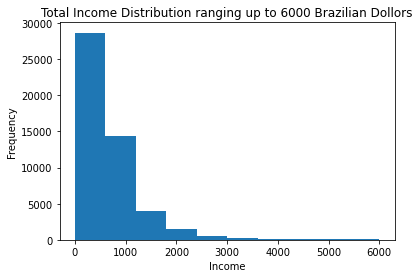

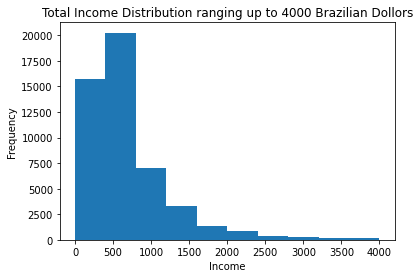

In [80]:
# take a look at income
plt.hist(df2["TOTAL_INCOME"],range=(0,6000))
#plt.savefig("Income.pdf")
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.title("Total Income Distribution ranging up to 6000 Brazilian Dollors")
plt.show()
plt.hist(df2["TOTAL_INCOME"],range=(0,4000))
#plt.savefig("Income2.pdf")
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.title("Total Income Distribution ranging up to 4000 Brazilian Dollors")
plt.show()

In [81]:
# only consider customers with total income less than or equal to 4000
df2 = df2.loc[df2["TOTAL_INCOME"] <= 4000]

## make new variables

In [82]:
# variable 1: supporting power of dependents and self
df2["SUPPORT_POWER"]=df2["TOTAL_INCOME"] / (df2["QUANT_DEPENDANTS"]+1)

# variable 2: accomplishment
df2["ACCOMPLISHMENT"]=df2["TOTAL_INCOME"] / df2["AGE"]

# variable 3: debt over standardized income
mean_income = df2.TOTAL_INCOME.mean()
std_income = df2.TOTAL_INCOME.std()
df2["DEBT"] = (df2["FLAG_VISA"]+df2["FLAG_MASTERCARD"]+df2["FLAG_DINERS"]+df2["FLAG_AMERICAN_EXPRESS"]+df2["FLAG_OTHER_CARDS"])

## split the data and replace missing values

In [83]:
# split the data into training and testing set with 70-30 ratio

train, test = sc.split_df(df2,y="TARGET_LABEL_BAD=1",ratio=0.7,seed=250918939).values()

W:\Tools\Anaconda3\envs\gpu\lib\site-packages\scorecardpy\condition_fun.py:62: UserWarning: There are blank strings in 3 columns, which are replaced with NaN. 
 (ColumnNames: STATE_OF_BIRTH, CITY_OF_BIRTH, RESIDENCIAL_BOROUGH)
  warnings.warn('There are blank strings in {} columns, which are replaced with NaN. \n (ColumnNames: {})'.format(len(blank_cols), ', '.join(blank_cols)))


In [84]:
# replace state of birth and city of birth by mode from the training set (replace missing values instead of null values)
temp_col = train.STATE_OF_BIRTH[train.STATE_OF_BIRTH != " "]
birthstate_mode = np.array(temp_col.mode())[0]
train["STATE_OF_BIRTH"].replace({" ":birthstate_mode},inplace=True)
test["STATE_OF_BIRTH"].replace({" ":birthstate_mode},inplace=True)
df2["STATE_OF_BIRTH"].replace({" ":birthstate_mode},inplace=True)

temp_col = train.CITY_OF_BIRTH[train.CITY_OF_BIRTH != " "]
birthcity_mode = np.array(temp_col.mode())[0]
train["CITY_OF_BIRTH"].replace({" ":birthcity_mode},inplace=True)
test["CITY_OF_BIRTH"].replace({" ":birthcity_mode},inplace=True)
df2["CITY_OF_BIRTH"].replace({" ":birthcity_mode},inplace=True)

# replace residential borough by the mode from the traiing set (missing values)
temp_col = train.RESIDENCIAL_BOROUGH[train.RESIDENCIAL_BOROUGH != " "]
residencialb_mode = np.array(temp_col.mode())[0]
train["RESIDENCIAL_BOROUGH"].replace({" ":residencialb_mode},inplace=True)
test["RESIDENCIAL_BOROUGH"].replace({" ":residencialb_mode},inplace=True)
df2["RESIDENCIAL_BOROUGH"].replace({" ":residencialb_mode},inplace=True)


# replace month in residence by the median (null values)
train.MONTHS_IN_RESIDENCE.fillna(value=train.MONTHS_IN_RESIDENCE.median(),inplace=True)
test.MONTHS_IN_RESIDENCE.fillna(value=train.MONTHS_IN_RESIDENCE.median(),inplace=True)
df2.MONTHS_IN_RESIDENCE.fillna(value=train.MONTHS_IN_RESIDENCE.median(),inplace=True)

In [85]:
# replace age < 18 by the median since those people won't be able to get a loan
age_median=train.AGE.median()
df2["AGE"] = df2.apply(lambda x: age_median if x["AGE"] < 18 else x["AGE"], axis=1)
train["AGE"] = train.apply(lambda x: age_median if x["AGE"] < 18 else x["AGE"], axis=1)
test["AGE"] = test.apply(lambda x: age_median if x["AGE"] < 18 else x["AGE"], axis=1)

In [86]:
# check if null values in the training set have been delt with
missing_col=np.zeros(len(df2.columns))
for k in np.arange(len(train)):
  count=0
  for i in np.arange(len(df2.columns)):
    val = train.iloc[k,i]
    #print(val)
    if val == " ":
      missing_col[i] += 1

# check the columns with " " value
for i in np.arange(len(missing_col)):
  if missing_col[i] != 0:
    print("{0:<30s}{1}".format(train.columns[i],int(missing_col[i])))

# recheck the columns with null values
null_columns = train.columns[train.isnull().any()]
train[null_columns].isnull().sum()

Series([], dtype: float64)

# Weight of Evidence Transformation and Logistic Model

## combining small categories

In [87]:
# standardizing cities nad boroughs
df2["CITY_OF_BIRTH"] = df2.apply(lambda x: (x["CITY_OF_BIRTH"].replace(" ","")).upper(), axis=1)
df2["RESIDENCIAL_CITY"] = df2.apply(lambda x: (x["RESIDENCIAL_CITY"].replace(" ","")).upper(), axis=1)
df2["RESIDENCIAL_BOROUGH"] = df2.apply(lambda x: (x["RESIDENCIAL_BOROUGH"].replace(" ","")).upper(), axis=1)

In [88]:
# stadnardizing the codes
df2["RESIDENCIAL_ZIP_3"] = df2.apply(lambda x: int(x["RESIDENCIAL_ZIP_3"]) if (
    (type(x["RESIDENCIAL_ZIP_3"])==int or type(x["RESIDENCIAL_ZIP_3"])==str) 
    and x["RESIDENCIAL_ZIP_3"] != "#DIV/0!") else 0, axis=1 )
df2["PROFESSIONAL_ZIP_3"] = df2.apply(lambda x: int(x["PROFESSIONAL_ZIP_3"]) if (
    (type(x["PROFESSIONAL_ZIP_3"])==int or type(x["PROFESSIONAL_ZIP_3"])==str) 
    and x["PROFESSIONAL_ZIP_3"] != "#DIV/0!") else 0, axis=1 )

In [89]:
# define a function that takes dataframe, varaible and return the categories with small counts
def retrieve(mincase,df,var):
    values = df[var].value_counts()
    values2 = pd.DataFrame(data=values)
    values2 = values2[values2[var]<mincase]
    values3 = np.array(values2.index)
    return values3

In [91]:
# find categories with small amount of cases and combine them
mincase=50
smallbirth_cities = retrieve(mincase,df2,"CITY_OF_BIRTH")
#print(smallbirth_cities)

smallres_cities = retrieve(mincase, df2, "RESIDENCIAL_CITY")

smallres_borough = retrieve(mincase, df2, "RESIDENCIAL_BOROUGH")

smallres_zip = retrieve(mincase, df2, "RESIDENCIAL_ZIP_3")

smallpro_zip = retrieve(mincase, df2, "PROFESSIONAL_ZIP_3")

In [92]:
# make sure that each category in categorical variables have good amount of cases
df2["CITY_OF_BIRTH"] = df2.apply(lambda x: "OTHERS" if x["CITY_OF_BIRTH"] in smallbirth_cities else x["CITY_OF_BIRTH"],
                                 axis=1)
df2["RESIDENCIAL_CITY"] = df2.apply(lambda x: "OTHERS" if x["RESIDENCIAL_CITY"] in smallres_cities else x["RESIDENCIAL_CITY"],
                                 axis=1)
df2["RESIDENCIAL_BOROUGH"] = df2.apply(lambda x: "OTHERS" if x["RESIDENCIAL_BOROUGH"] in smallres_borough else x["RESIDENCIAL_BOROUGH"],
                                 axis=1)
df2["RESIDENCIAL_ZIP_3"] = df2.apply(lambda x: 0 if x["RESIDENCIAL_ZIP_3"] in smallres_zip else x["RESIDENCIAL_ZIP_3"],
                                     axis=1)
df2["PROFESSIONAL_ZIP_3"] = df2.apply(lambda x: 0 if x["PROFESSIONAL_ZIP_3"] in smallpro_zip else x["PROFESSIONAL_ZIP_3"],
                                     axis=1)

## create bins

In [94]:
# split again
train, test = sc.split_df(df2,y="TARGET_LABEL_BAD=1",ratio=0.7,seed=250918939).values()

In [96]:
# with some testing, decided to drop the variables with 0 and almost 0 information values
df3 = df2.loc[:,["OCCUPATION_TYPE","RESIDENCIAL_STATE","MARITAL_STATUS",
                 "RESIDENCIAL_ZIP_3",
                 "AGE", "PAYMENT_DAY", "PROFESSIONAL_ZIP_3","ACCOMPLISHMENT","TARGET_LABEL_BAD=1"]]
train = train.loc[:,["OCCUPATION_TYPE","RESIDENCIAL_STATE","MARITAL_STATUS",
                 "RESIDENCIAL_ZIP_3",
                 "AGE", "PAYMENT_DAY", "PROFESSIONAL_ZIP_3","ACCOMPLISHMENT",
                 "TARGET_LABEL_BAD=1"]]
test = test.loc[:,["OCCUPATION_TYPE","RESIDENCIAL_STATE","MARITAL_STATUS",
                 "RESIDENCIAL_ZIP_3",
                 "AGE", "PAYMENT_DAY", "PROFESSIONAL_ZIP_3","ACCOMPLISHMENT",
                 "TARGET_LABEL_BAD=1"]]

In [97]:
# Try with 100 cuts, minimum 2% data(1000 cases) per bin and maximum 7 bins
bins3 = sc.woebin(train, y="TARGET_LABEL_BAD=1",
                  min_perc_fine_bin=0.01,
                  min_perc_coarse_bin=0.05,
                  stop_limit=0.02,
                  max_num_bin=7,
                  method="tree"
                  )

[INFO] creating woe binning ...


-------- 1/8 RESIDENCIAL_ZIP_3 --------
>>> dt[RESIDENCIAL_ZIP_3].describe(): 
count    34680.000000
mean       493.526413
std        295.999862
min          0.000000
25%        286.000000
50%        572.000000
75%        689.000000
max        980.000000
Name: RESIDENCIAL_ZIP_3, dtype: float64 



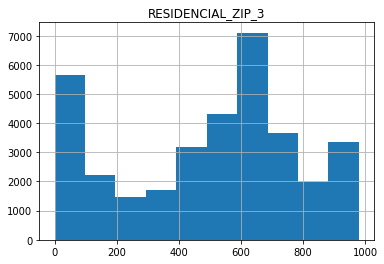

>>> Current breaks:
130.0,400.0,610.0,690.0,750.0,950.0 



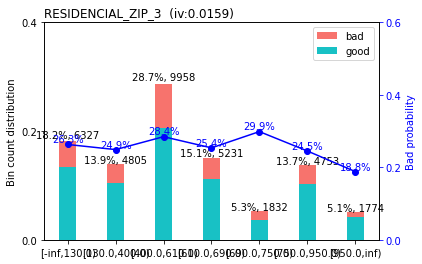

>>> Adjust breaks for (1/8) RESIDENCIAL_ZIP_3?
1: next 
2: yes 
3: back
Selection: 1
-------- 2/8 MARITAL_STATUS --------
>>> dt[MARITAL_STATUS].describe(): 
count    34680.000000
mean         2.143829
std          1.317922
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          7.000000
Name: MARITAL_STATUS, dtype: float64 

>>> dt[MARITAL_STATUS].value_counts(): 
2    17986
1    10678
4     2927
6     1313
5      871
3      431
7      352
0      122
Name: MARITAL_STATUS, dtype: int64 

>>> Current breaks:
2.0,3.0,5.0 



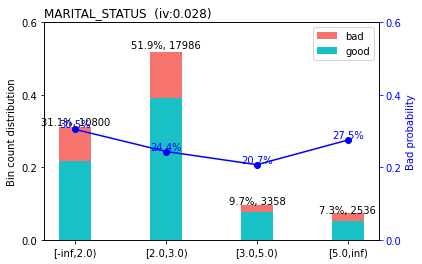

>>> Adjust breaks for (2/8) MARITAL_STATUS?
1: next 
2: yes 
3: back
Selection: 1
-------- 3/8 PROFESSIONAL_ZIP_3 --------
>>> dt[PROFESSIONAL_ZIP_3].describe(): 
count    34680.000000
mean       493.526413
std        295.999862
min          0.000000
25%        286.000000
50%        572.000000
75%        689.000000
max        980.000000
Name: PROFESSIONAL_ZIP_3, dtype: float64 



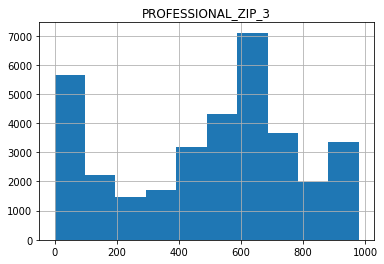

>>> Current breaks:
130.0,400.0,610.0,690.0,750.0,950.0 



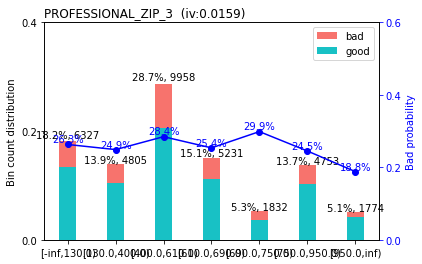

>>> Adjust breaks for (3/8) PROFESSIONAL_ZIP_3?
1: next 
2: yes 
3: back
Selection: 1
-------- 4/8 PAYMENT_DAY --------
>>> dt[PAYMENT_DAY].describe(): 
count    34680.000000
mean        12.889937
std          6.602135
min          1.000000
25%         10.000000
50%         10.000000
75%         15.000000
max         25.000000
Name: PAYMENT_DAY, dtype: float64 

>>> dt[PAYMENT_DAY].value_counts(): 
10    14109
15     6110
5      5106
25     4864
20     3298
1      1193
Name: PAYMENT_DAY, dtype: int64 

>>> Current breaks:
10.0,15.0,20.0,25.0 



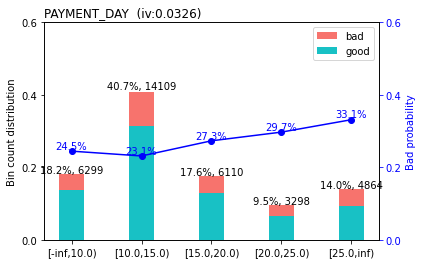

>>> Adjust breaks for (4/8) PAYMENT_DAY?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 11,18
[INFO] creating woe binning ...
>>> Current breaks:
11.0, 18.0 



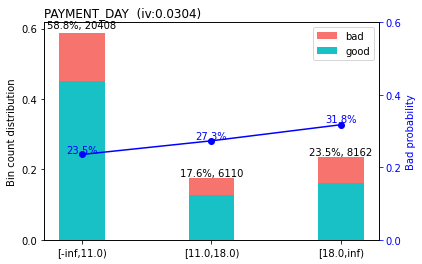

>>> Adjust breaks for (4/8) PAYMENT_DAY?
1: next 
2: yes 
3: back
Selection: 1
-------- 5/8 AGE --------
>>> dt[AGE].describe(): 
count    34680.000000
mean        43.140398
std         15.050384
min         18.000000
25%         31.000000
50%         41.000000
75%         53.000000
max        106.000000
Name: AGE, dtype: float64 



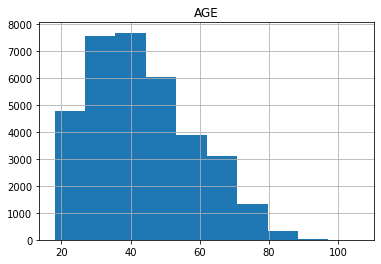

>>> Current breaks:
22.0,33.0,44.0,47.0,55.0,70.0 



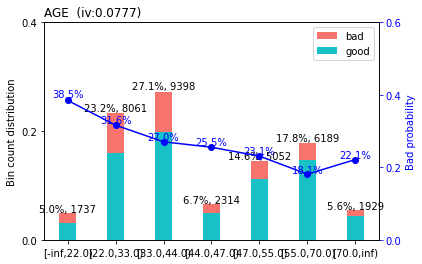

>>> Adjust breaks for (5/8) AGE?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 26,33,43,49,60
[INFO] creating woe binning ...
>>> Current breaks:
60.0, 49.0, 26.0, 33.0, 43.0 



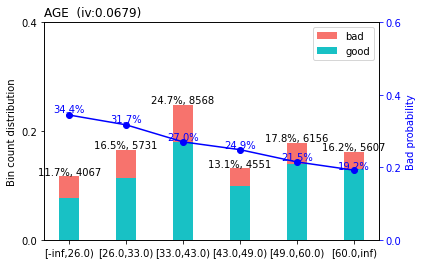

>>> Adjust breaks for (5/8) AGE?
1: next 
2: yes 
3: back
Selection: 1
-------- 6/8 RESIDENCIAL_STATE --------
>>> dt[RESIDENCIAL_STATE].describe(): 
count     34680
unique       27
top          SP
freq       6127
Name: RESIDENCIAL_STATE, dtype: object 

>>> dt[RESIDENCIAL_STATE].value_counts(): 
SP    6127
RS    3652
BA    3548
CE    3235
PE    2517
MG    2153
PA    1551
RJ    1469
RN    1404
GO    1131
PR    1069
AL    1001
PB     912
MT     893
MA     515
MS     513
ES     491
DF     469
SC     442
AP     335
AM     281
PI     254
RO     244
SE     184
AC     160
TO      87
RR      43
Name: RESIDENCIAL_STATE, dtype: int64 

>>> Current breaks:
'SC%,%RO%,%RS','PR%,%PB','PA%,%MG%,%AP','AC%,%MA%,%SP','MS%,%TO%,%RJ%,%MT%,%CE%,%PI','GO%,%BA%,%RR%,%RN%,%PE%,%ES','AL%,%AM%,%DF%,%SE' 



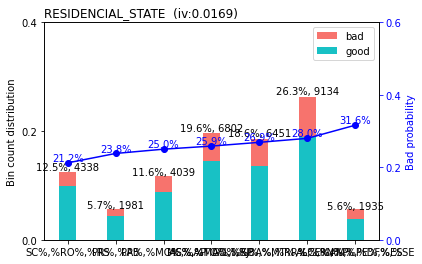

>>> Adjust breaks for (6/8) RESIDENCIAL_STATE?
1: next 
2: yes 
3: back
Selection: 1
-------- 7/8 OCCUPATION_TYPE --------
>>> dt[OCCUPATION_TYPE].describe(): 
count    34680.000000
mean         3.001557
std          1.882931
min          0.000000
25%          2.000000
50%          2.000000
75%          5.000000
max          6.000000
Name: OCCUPATION_TYPE, dtype: float64 

>>> dt[OCCUPATION_TYPE].value_counts(): 
2.0    11865
1.0     6000
6.0     5117
4.0     4827
5.0     4743
0.0     1915
3.0      213
Name: OCCUPATION_TYPE, dtype: int64 

>>> Current breaks:
1.0,2.0,4.0,5.0,6.0 



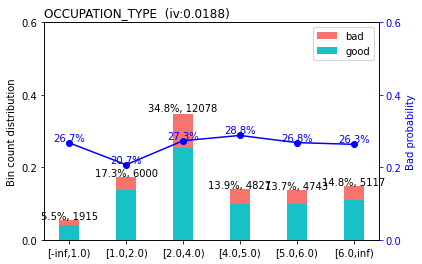

>>> Adjust breaks for (7/8) OCCUPATION_TYPE?
1: next 
2: yes 
3: back
Selection: 1
-------- 8/8 ACCOMPLISHMENT --------
>>> dt[ACCOMPLISHMENT].describe(): 
count    34680.000000
mean        17.901907
std         13.347868
min          1.754386
25%          9.090909
50%         14.317627
75%         22.254798
max        194.000000
Name: ACCOMPLISHMENT, dtype: float64 



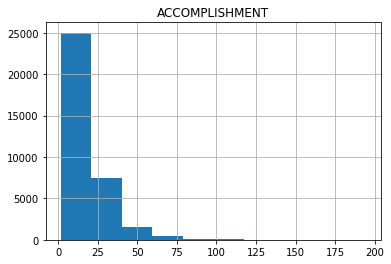

>>> Current breaks:
8.0,12.0,23.0,43.0 



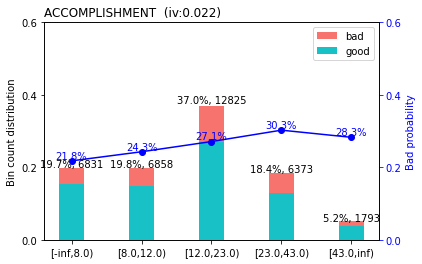

>>> Adjust breaks for (8/8) ACCOMPLISHMENT?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 8,12,23
[INFO] creating woe binning ...
>>> Current breaks:
8.0, 23.0, 12.0 



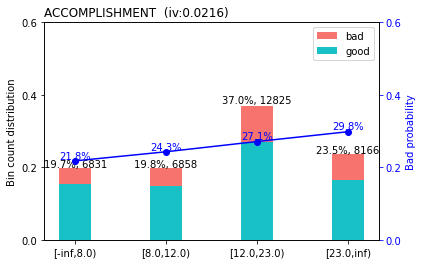

>>> Adjust breaks for (8/8) ACCOMPLISHMENT?
1: next 
2: yes 
3: back
Selection: 1


In [99]:
# adjust bins so that they represent meaningful trends
breaks_adj = sc.woebin_adj(train, "TARGET_LABEL_BAD=1", bins3, adj_all_var=True)

In [100]:
# apply the adjusted cuts
bins_final = sc.woebin(train, y="TARGET_LABEL_BAD=1",breaks_list=breaks_adj)
# calculate WoE dataset
train_woe = sc.woebin_ply(train, bins_final)
test_woe = sc.woebin_ply(test, bins_final)

[INFO] creating woe binning ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [101]:
# infomration value
sc.iv(train_woe,"TARGET_LABEL_BAD=1")

,variable,info_value
7,AGE_woe,0.067863
3,PAYMENT_DAY_woe,0.030390
4,MARITAL_STATUS_woe,0.027959
6,ACCOMPLISHMENT_woe,0.021630
2,OCCUPATION_TYPE_woe,0.018840
1,RESIDENCIAL_STATE_woe,0.016862
0,PROFESSIONAL_ZIP_3_woe,0.015906
5,RESIDENCIAL_ZIP_3_woe,0.015906


## correlation check

<AxesSubplot:>

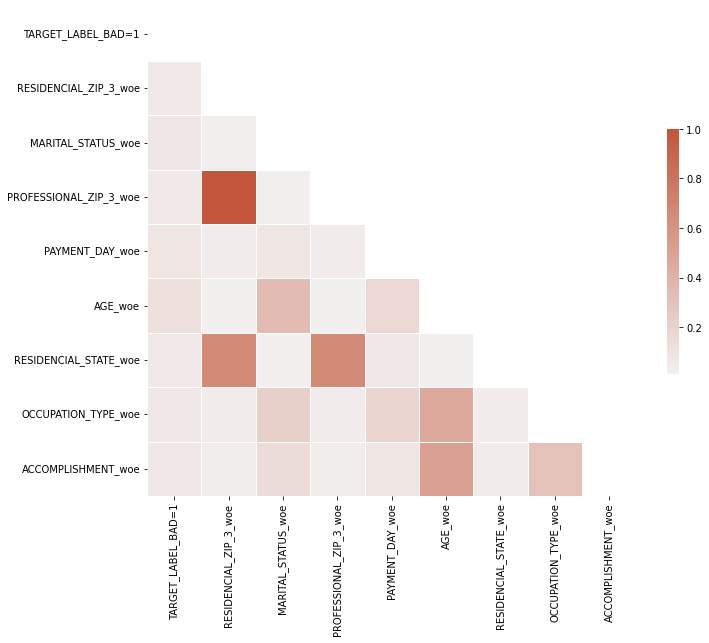

In [102]:
# compute the correlation matrix
corr = train_woe.corr()
corr = np.abs(corr)

# generate a mask for the upper triangle correlation matrix
mask = np.triu(np.ones_like(corr,dtype=bool))

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# generate a diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# draw the heatmap with the mask nad correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [103]:
# removing residencial zip code
df3 = df2.loc[:,["OCCUPATION_TYPE","RESIDENCIAL_STATE","MARITAL_STATUS",
                 "AGE", "PAYMENT_DAY", "PROFESSIONAL_ZIP_3","ACCOMPLISHMENT","TARGET_LABEL_BAD=1"]]
train = train.loc[:,["OCCUPATION_TYPE","RESIDENCIAL_STATE","MARITAL_STATUS",
                 "AGE", "PAYMENT_DAY", "PROFESSIONAL_ZIP_3","ACCOMPLISHMENT",
                 "TARGET_LABEL_BAD=1"]]
test = test.loc[:,["OCCUPATION_TYPE","RESIDENCIAL_STATE","MARITAL_STATUS",
                 "AGE", "PAYMENT_DAY", "PROFESSIONAL_ZIP_3","ACCOMPLISHMENT",
                 "TARGET_LABEL_BAD=1"]]
# calculate WoE dataset
train_woe = sc.woebin_ply(train, bins_final)
test_woe = sc.woebin_ply(test, bins_final)
train_woe.head()

[INFO] converting into woe values ...
[INFO] converting into woe values ...


,TARGET_LABEL_BAD=1,MARITAL_STATUS_woe,PROFESSIONAL_ZIP_3_woe,PAYMENT_DAY_woe,AGE_woe,RESIDENCIAL_STATE_woe,OCCUPATION_TYPE_woe,ACCOMPLISHMENT_woe
1,1,-0.094251,-0.065840,0.059953,0.044956,0.038654,0.133313,0.049615
2,0,-0.094251,0.116334,-0.139198,0.272041,0.093864,0.010420,0.049615
3,0,-0.094251,0.116334,0.273643,-0.396786,0.093864,0.010420,-0.098086
4,1,-0.094251,-0.065840,-0.139198,-0.066754,0.038654,0.034756,0.182665
5,1,-0.094251,-0.065840,-0.139198,0.044956,-0.059674,0.060699,0.049615


## train the model

In [104]:
score_logreg = LogisticRegressionCV(penalty="elasticnet",
              Cs = [i for i in range(10,50)],  # try 40 parameters
              tol = 0.0001,
              cv = 3,
              fit_intercept=True,
              class_weight = "balanced",
              random_state = 250918939,
              max_iter = 100,
              verbose = 0,
              solver = "saga",
              n_jobs=2, 
              refit = True,
              l1_ratios = np.arange(0, 1.01, 0.1))

In [105]:
score_logreg.fit(X = train_woe.iloc[:,1:], y=train_woe["TARGET_LABEL_BAD=1"])

LogisticRegressionCV(Cs=[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                         24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
                         38, 39, ...],
                     class_weight='balanced', cv=3,
                     l1_ratios=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                     n_jobs=2, penalty='elasticnet', random_state=250918939,
                     solver='saga')

In [106]:
# parameters: should not expect negative coefficients
coef_df = pd.concat([pd.DataFrame({"columns":train_woe.columns[1:]}),
                     pd.DataFrame(np.transpose(score_logreg.coef_))],
                    axis=1)
coef_df

,columns,0
0,MARITAL_STATUS_woe,0.514044
1,PROFESSIONAL_ZIP_3_woe,0.590490
2,PAYMENT_DAY_woe,0.750327
3,AGE_woe,0.765557
4,RESIDENCIAL_STATE_woe,0.576933
5,OCCUPATION_TYPE_woe,-0.054264
6,ACCOMPLISHMENT_woe,0.216293


## test performance

In [108]:
# apply the model to test set
pred_test = score_logreg.predict(test_woe.drop(axis=1,columns="TARGET_LABEL_BAD=1"))

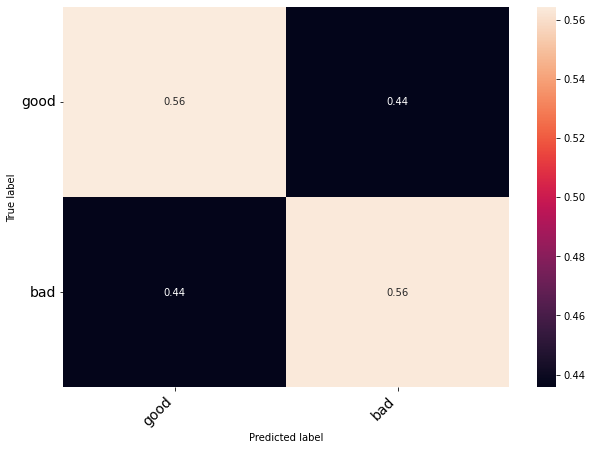

In [109]:
# Calculate confusion matrix
confusion_matrix_logreg = confusion_matrix(y_true=test["TARGET_LABEL_BAD=1"],y_pred = pred_test)

# turn matrix to percentage
confusion_matrix_logreg = confusion_matrix_logreg.astype("float") / confusion_matrix_logreg.sum(axis=1)[:,np.newaxis]

# turn to dataframe
df_cm = pd.DataFrame(confusion_matrix_logreg, index=["good", "bad"], columns=["good", "bad"])

# parameters of the image
figsize = (10, 7)
fontsize = 14

# Crate image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm,annot=True,fmt=".2f")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha="right", fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha="right", fontsize=fontsize)

plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

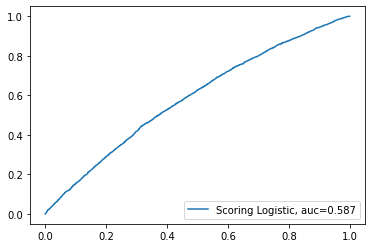

In [110]:
# calculate the ROC curve points
pred_test_prob = score_logreg.predict_proba(test_woe.drop(axis=1,columns="TARGET_LABEL_BAD=1"))
fpr, tpr, thresholds = roc_curve(test["TARGET_LABEL_BAD=1"],pred_test_prob[:,1])

auc = np.round(roc_auc_score(y_true=test["TARGET_LABEL_BAD=1"], y_score=pred_test_prob[:,1]),decimals=3)

plt.plot(fpr, tpr, label="Scoring Logistic, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [111]:
# varaible importance
sc.iv(train_woe,"TARGET_LABEL_BAD=1")

,variable,info_value
6,AGE_woe,0.067863
3,PAYMENT_DAY_woe,0.030390
4,MARITAL_STATUS_woe,0.027959
5,ACCOMPLISHMENT_woe,0.021630
2,OCCUPATION_TYPE_woe,0.018840
1,RESIDENCIAL_STATE_woe,0.016862
0,PROFESSIONAL_ZIP_3_woe,0.015906


# Define Credit Scorecard

In [112]:
# tring a set of number
score_sc = sc.scorecard(bins_final,score_logreg,train_woe.columns[1:],points0=800,odds0=0.2,pdo=200)
my_score = sc.scorecard_ply(df3,score_sc,print_step=False)
my_score.describe()

,score
count,49543.000000
mean,344.276043
std,97.534830
min,71.000000
25%,275.000000
50%,342.000000
75%,414.000000
max,632.000000


The statsitics of strategy related to the score card can be found in the report

# Random Forest

In [113]:
# one hot encode every categorical variable
df2["PROFESSIONAL_ZIP_3"] = df2["PROFESSIONAL_ZIP_3"].astype("category")
df2["RESIDENCIAL_ZIP_3"] = df2["RESIDENCIAL_ZIP_3"].astype("category")
df2["PRODUCT"] = df2["PRODUCT"].astype("category")
df2["OCCUPATION_TYPE"] = df2["OCCUPATION_TYPE"].astype("category")
df2["PROFESSION_CODE"] = df2["PROFESSION_CODE"].astype("category")
df2["FLAG_PROFESSIONAL_PHONE"] = df2["FLAG_PROFESSIONAL_PHONE"].astype("category")
df2["COMPANY"] = df2["COMPANY"].astype("category")
df2["QUANT_SPECIAL_BANKING_ACCOUNTS"] = df2["QUANT_SPECIAL_BANKING_ACCOUNTS"].astype("category")
df2["QUANT_BANKING_ACCOUNTS"] = df2["QUANT_BANKING_ACCOUNTS"].astype("category")
df2["FLAG_OTHER_CARDS"] = df2["FLAG_OTHER_CARDS"].astype("category")
df2["FLAG_AMERICAN_EXPRESS"] = df2["FLAG_AMERICAN_EXPRESS"].astype("category")
df2["FLAG_DINERS"] = df2["FLAG_DINERS"].astype("category")
df2["FLAG_MASTERCARD"] = df2["FLAG_MASTERCARD"].astype("category")
df2["FLAG_VISA"] = df2["FLAG_VISA"].astype("category")
df2["FLAG_EMAIL"] = df2["FLAG_EMAIL"].astype("category")
df2["RESIDENCE_TYPE"] = df2["RESIDENCE_TYPE"].astype("category")
df2["MARITAL_STATUS"] = df2["MARITAL_STATUS"].astype("category")
df2["RESIDENCIAL_STATE"] = df2["RESIDENCIAL_STATE"].astype("category")
df2["PROFESSIONAL_ZIP_3"] = df2["PROFESSIONAL_ZIP_3"].astype("category")
df2["APPLICATION_SUBMISSION_TYPE"] = df2["APPLICATION_SUBMISSION_TYPE"].astype("category")
df2["POSTAL_ADDRESS_TYPE"] = df2["POSTAL_ADDRESS_TYPE"].astype("category")
df2["QUANT_DEPENDANTS"] = df2["QUANT_DEPENDANTS"].astype("category")
df2["STATE_OF_BIRTH"] = df2["STATE_OF_BIRTH"].astype("category")
df2["CITY_OF_BIRTH"] = df2["CITY_OF_BIRTH"].astype("category")
df2["NACIONALITY"] = df2["NACIONALITY"].astype("category")
df2["RESIDENCIAL_STATE"] = df2["RESIDENCIAL_STATE"].astype("category")
df2["RESIDENCIAL_CITY"] = df2["RESIDENCIAL_CITY"].astype("category")
df2["RESIDENCIAL_BOROUGH"] = df2["RESIDENCIAL_BOROUGH"].astype("category")
df2["FLAG_RESIDENCIAL_PHONE"] = df2["FLAG_RESIDENCIAL_PHONE"].astype("category")
df7 = pd.get_dummies(df2)

In [114]:
# split again
train, test = sc.split_df(df7,y="TARGET_LABEL_BAD=1",ratio=0.7,seed=250918939).values()

In [117]:
# define random forest classifier
score_rf = RandomForestClassifier(n_estimators = 1000,
                  criterion = "entropy",
                  max_depth=None,
                  min_samples_split=2,
                  min_samples_leaf=0.0001,
                  min_weight_fraction_leaf = 0,
                  max_features = "auto",
                  max_leaf_nodes=None,
                  min_impurity_decrease=0.0001,
                  bootstrap = True,
                  oob_score = True,
                  n_jobs=6,
                  random_state = 250918939,
                  verbose = 1,
                  warm_start = False,
                  class_weight="balanced"
                  )

In [118]:
# Train the RF
score_rf.fit(train.drop(axis=1,columns="TARGET_LABEL_BAD=1"),train["TARGET_LABEL_BAD=1"])

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    7.5s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   17.3s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   31.2s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:   39.6s finished
W:\Tools\Anaconda3\envs\gpu\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       min_impurity_decrease=0.0001, min_samples_leaf=0.0001,
                       min_weight_fraction_leaf=0, n_estimators=1000, n_jobs=6,
                       oob_score=True, random_state=250918939, verbose=1)

## check performance

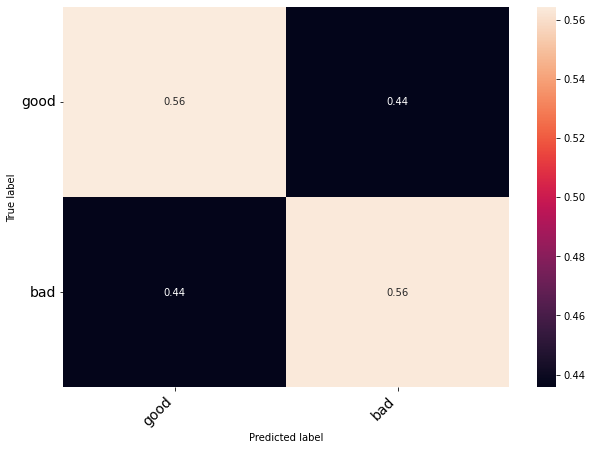

In [119]:
# Calculate confusion matrix
confusion_matrix_rf = confusion_matrix(y_true=test["TARGET_LABEL_BAD=1"],y_pred = pred_test)

# turn matrix to percentage
confusion_matrix_rf = confusion_matrix_rf.astype("float") / confusion_matrix_rf.sum(axis=1)[:,np.newaxis]

# turn to dataframe
df_cm = pd.DataFrame(confusion_matrix_rf, index=["good", "bad"], columns=["good", "bad"])

# parameters of the image
figsize = (10, 7)
fontsize = 14

# Crate image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm,annot=True,fmt=".2f")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha="right", fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha="right", fontsize=fontsize)

plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    0.5s finished


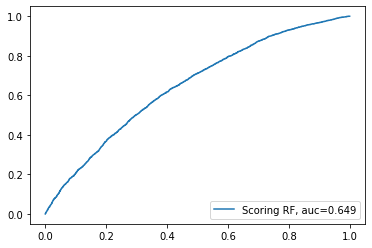

In [120]:
# calculate the ROC curve points
pred_test_prob = score_rf.predict_proba(test.drop(axis=1,columns="TARGET_LABEL_BAD=1"))
fpr, tpr, thresholds = roc_curve(test["TARGET_LABEL_BAD=1"],pred_test_prob[:,1])

auc = np.round(roc_auc_score(y_true=test["TARGET_LABEL_BAD=1"], y_score=pred_test_prob[:,1]),decimals=3)

plt.plot(fpr, tpr, label="Scoring RF, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## variable importance

In [121]:
# variable importance
importances = score_rf.feature_importances_
indices = np.argsort(importances)[::-1]
columns = train.drop(axis=1,columns="TARGET_LABEL_BAD=1")
columns = columns.columns
columns_importance = columns[indices]
#print(columns_importance[:30])

for i in np.arange(13):
  print("{0:<30s}{1}".format(columns_importance[i],round(importances[indices[i]],4)))

AGE                           0.0885
ACCOMPLISHMENT                0.0487
PAYMENT_DAY                   0.0334
TOTAL_INCOME                  0.0284
PERSONAL_MONTHLY_INCOME       0.0281
SUPPORT_POWER                 0.0277
FLAG_RESIDENCIAL_PHONE_N      0.025
FLAG_RESIDENCIAL_PHONE_Y      0.0237
MONTHS_IN_RESIDENCE           0.0183
MARITAL_STATUS_1              0.0182
OCCUPATION_TYPE_1.0           0.0141
MARITAL_STATUS_2              0.0097
CITY_OF_BIRTH_OTHERS          0.0085


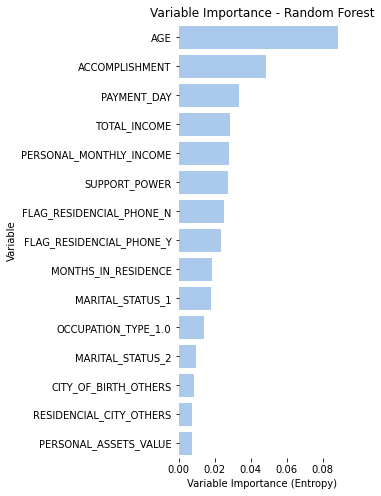

In [122]:
# plot variable importance
f, ax = plt.subplots(figsize=(3,8))
plt.title("Variable Importance - Random Forest")
sns.set_color_codes("pastel")
train2 = train.drop(axis=1,columns="TARGET_LABEL_BAD=1")
sns.barplot(y=[train2.columns[i] for i in indices[:15]], x=importances[indices[:15]],
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Entropy)")
sns.despine(left=True,bottom=True)

# XGBoosting

In [144]:
# define the classifier
score_XGB = XGBClassifier(max_depth=2, learning_rate=0.1,n_estimators=50,verbosity=1,objective="binary:logistic",
              booster="gbtree",n_jobs=5,gamma=0.01,subsample=0.632,colsample_bytree=1,colsample_bylevel=1,
              colsample_bynode=1,reg_alpha=1,reg_lambda=0,scale_pos_wieght=36592/12951,
              base_score=0.5,random_state=250918939,missing=1,tree_method="gpu_hist",
              gpu_id=1)

## use cross validation to find optimal parameters

In [145]:
# potential parameters
param_grid=dict({"n_estimators":[50,75,100],
         "max_depth": [2,3,4],
         "learning_rate": [0.01,0.05,0.1,0.15]})

# reduce the sample to train for the parameters
val_train = train.sample(frac=0.2, random_state=250918939)

# define the grid search object
GridXGB = GridSearchCV(score_XGB, param_grid, cv=5, scoring="roc_auc", n_jobs=5, refit=False, verbose=2)
# train for the optimal parameter
GridXGB.fit(val_train.drop(axis=1,columns="TARGET_LABEL_BAD=1"),val_train["TARGET_LABEL_BAD=1"])

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False, gamma=0.01,
                                     gpu_id=1, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=1, monotone_constraints=None,
                                     n_estimators=50...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=250918939, reg_alpha=1,
                                     reg_lambda=0, scale_pos_weight=None,
                                     scale_pos_wieght=2.82

In [146]:
# show best params
print("The best AUC is %.3f" % GridXGB.best_score_)
GridXGB.best_params_

The best AUC is 0.621


{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 75}

## fit the model with best parameters

In [149]:
# create XG boosting with the best parameter
score_XGB = XGBClassifier(max_depth=2, learning_rate=0.1,n_estimators=100,verbosity=1,objective="binary:logistic",
              booster="gbtree",n_jobs=2,gamma=0.000001,subsample=0.632,colsample_bytree=1,colsample_bylevel=1,
              colsample_bynode=1,reg_alpha=1,reg_lambda=0,scale_pos_wieght=36592/12951,
              base_score=0.5,random_state=250918939,missing=1,tree_method="gpu_hist",
              gpu_id=0)

# train over all training data
score_XGB.fit(train.drop(axis=1,columns="TARGET_LABEL_BAD=1"),train["TARGET_LABEL_BAD=1"])

W:\Tools\Anaconda3\envs\gpu\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:52:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_wieght" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1e-06, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=1,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=250918939,
              reg_alpha=1, reg_lambda=0, scale_pos_weight=1,
              scale_pos_wieght=2.8254188865724656, subsample=0.632,
              tree_method='gpu_hist', validate_parameters=1, verbosity=1)

## test performance

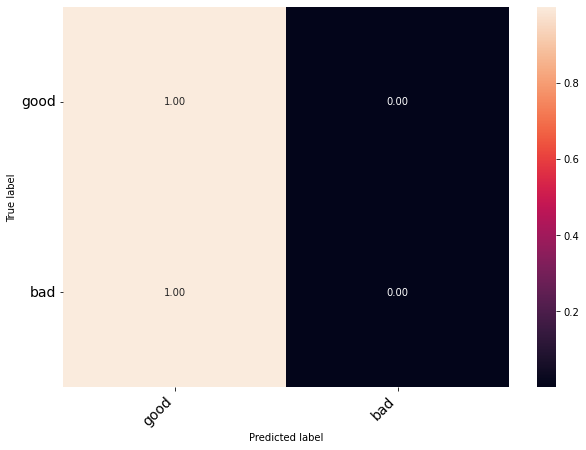

In [150]:
# apply the model to test set
pred_test2 = score_XGB.predict(test.drop(axis=1,columns="TARGET_LABEL_BAD=1"))

# Calculate confusion matrix
confusion_matrix_XGB = confusion_matrix(y_true=test["TARGET_LABEL_BAD=1"],y_pred = pred_test2)

# turn matrix to percentage
confusion_matrix_XGB = confusion_matrix_XGB.astype("float") / confusion_matrix_XGB.sum(axis=1)[:,np.newaxis]

# turn to dataframe
df_cm = pd.DataFrame(confusion_matrix_XGB, index=["good", "bad"], columns=["good", "bad"])

# parameters of the image
figsize = (10, 7)
fontsize = 14

# Crate image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm,annot=True,fmt=".2f")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha="right", fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha="right", fontsize=fontsize)

plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

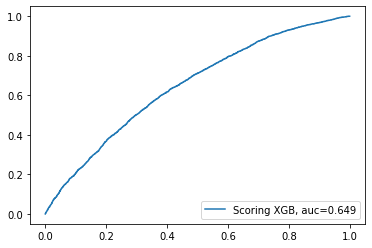

In [151]:
# calculate the ROC curve points
pred_test_prob2 = score_XGB.predict_proba(test.drop(axis=1,columns="TARGET_LABEL_BAD=1"))
fpr, tpr, thresholds = roc_curve(test["TARGET_LABEL_BAD=1"],pred_test_prob[:,1])

auc = np.round(roc_auc_score(y_true=test["TARGET_LABEL_BAD=1"], y_score=pred_test_prob[:,1]),decimals=3)

plt.plot(fpr, tpr, label="Scoring XGB, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## variable importance

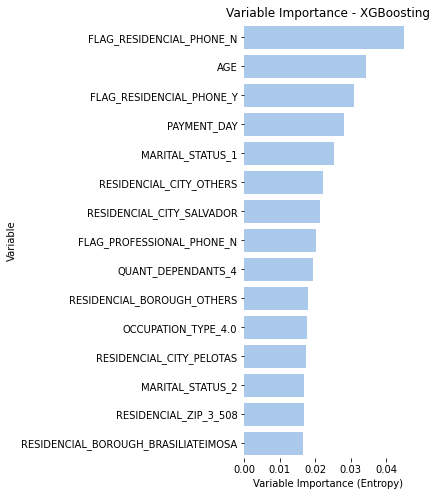

In [152]:
# plot variable importance
importances2 = score_XGB.feature_importances_
indices2 = np.argsort(importances2)[::-1]

f, ax = plt.subplots(figsize=(3,8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
train2 = train.drop(axis=1,columns="TARGET_LABEL_BAD=1")
sns.barplot(y=[train2.columns[i] for i in indices2[:15]], x=importances2[indices2[:15]],
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Entropy)")
sns.despine(left=True,bottom=True)